# Overview :  Fine-tune SAM on a Blood Cancer Cells



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q monai

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install pycocotools

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Resize

In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


# Constants

In [ ]:
PROJECT_PATH = "/content/drive/MyDrive/projects/blood_cancer_project/sam_model_blood_cancer_project (1)"
DATASET_PATH = os.path.join(PROJECT_PATH,"dataset_coco")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load dataset



In [ ]:
# Load the COCO dataset
import os
from pycocotools.coco import COCO
coco = COCO(os.path.join( DATASET_PATH,'train/instances_default.json'))
image_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
class BloodCellSegmentationDataset2(Dataset):
    def __init__(self, root_dir, ann_file, transforms=None, save_masks=False, target_size=(256, 256)):
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgToAnns.keys())
        self.transforms = transforms
        self.save_masks = save_masks
        self.target_size = target_size
        self.resize = Resize(target_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # load the image
        img_path = os.path.join(self.root_dir, self.coco.loadImgs(img_id)[0]['file_name'])
        img = Image.open(img_path).convert('RGB')

        # resize the image
        img = self.resize(img)

        # generate the segmentation mask and calculate center points
        mask = np.zeros(self.target_size, dtype=np.uint8)
        centers = []
        for ann in anns:
            mask_ann = self.coco.annToMask(ann) * (1 if ann['category_id'] == 1 else 2)
            mask_ann = Image.fromarray(mask_ann)
            mask_ann = self.resize(mask_ann)
            mask_ann = np.array(mask_ann)
            mask += mask_ann
            center_x, center_y = self.get_mask_center(mask_ann)
            centers.append((center_x, center_y))

        # save the mask image if requested
        if self.save_masks:
            mask_path = os.path.join(self.root_dir, os.path.splitext(self.coco.loadImgs(img_id)[0]['file_name'])[0] + '_mask.png')
            Image.fromarray(mask).save(mask_path)

        # apply transformations if specified
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        # convert the mask to PyTorch tensor
        mask = torch.from_numpy(mask)

        #return img, mask, centers
        return img, mask

    def get_mask_center(self, mask):
        """
        Calculates the center point of a binary mask.
        """
        indices = np.argwhere(mask)
        if len(indices) == 0:
            return 0, 0
        x_coords, y_coords = indices[:, 1], indices[:, 0]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        return int(center_x), int(center_y)





class BloodCellSegmentationDataset3(Dataset):
    def __init__(self, root_dir, ann_file, transforms=None, save_masks=False, target_size=(256, 256)):
        self.root_dir = root_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgToAnns.keys())
        self.transforms = transforms
        self.save_masks = save_masks
        self.target_size = target_size
        self.resize = Resize(target_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # load the image
        img_path = os.path.join(self.root_dir, self.coco.loadImgs(img_id)[0]['file_name'])
        img = Image.open(img_path).convert('RGB')

        # resize the image
        img = self.resize(img)

        # generate the segmentation mask and calculate center points
        mask = np.zeros(self.target_size, dtype=np.uint8)
        centers = []
        for ann in anns:
            mask_ann = self.coco.annToMask(ann) * (1 if ann['category_id'] == 1 else 2)
            mask_ann = Image.fromarray(mask_ann)
            mask_ann = self.resize(mask_ann)
            mask_ann = np.array(mask_ann)
            mask += mask_ann
            center_x, center_y = self.get_mask_center(mask_ann)
            centers.append((center_x, center_y))

        # save the mask image if requested
        if self.save_masks:
            mask_path = os.path.join(self.root_dir, os.path.splitext(self.coco.loadImgs(img_id)[0]['file_name'])[0] + '_mask.png')
            Image.fromarray(mask).save(mask_path)

        # apply transformations if specified
        if self.transforms is not None:
            img, mask = self.transforms(img, mask)

        # convert the mask to PyTorch tensor
        mask = torch.from_numpy(mask)

        return img, mask, centers


    def get_mask_center(self, mask):
        """
        Calculates the center point of a binary mask.
        """
        indices = np.argwhere(mask)
        if len(indices) == 0:
            return 0, 0
        x_coords, y_coords = indices[:, 1], indices[:, 0]
        center_x = np.mean(x_coords)
        center_y = np.mean(y_coords)
        return int(center_x), int(center_y)

### Visualize Dataset

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


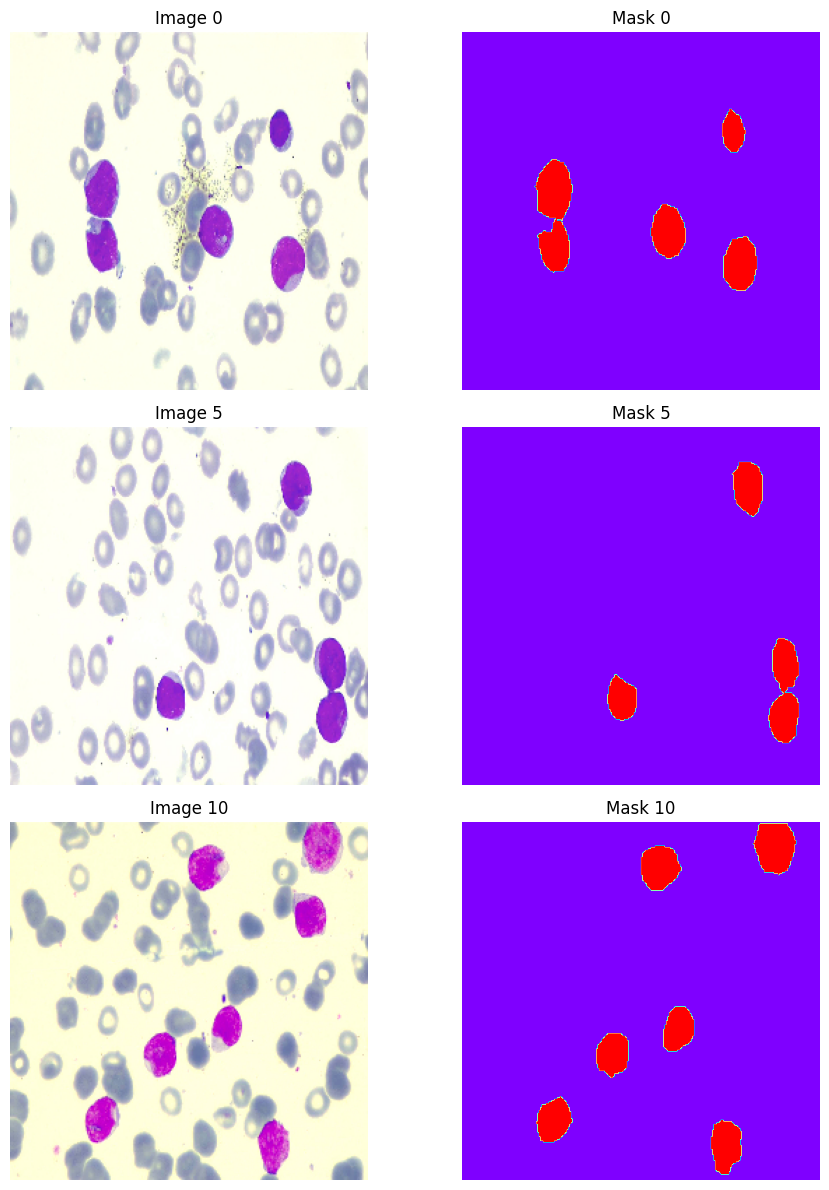

In [ ]:
from torchvision.transforms import Resize

root_dir =os.path.join( DATASET_PATH,'train')
#ann_file =os.path.join( root_dir,'instances_default.json')
ann_file = os.path.join(root_dir, 'instances_default.json')


# Create the dataset

dataset = BloodCellSegmentationDataset2(root_dir, ann_file, transforms=None)

dataset_c = BloodCellSegmentationDataset3(root_dir, ann_file, transforms=None)
sample_indices = [0, 5, 10]

# visualize the samples
fig, axs = plt.subplots(len(sample_indices), 2, figsize=(10, 4 * len(sample_indices)))

for i, idx in enumerate(sample_indices):
    img, mask = dataset[idx]

    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f'Image {idx}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='rainbow')
    axs[i, 1].set_title(f'Mask {idx}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
np_config.enable_numpy_behavior()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="red",
        marker="X",
        s=marker_size,
        edgecolor="white",
        linewidth=1.5,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="blue",
        marker="X",
        s=marker_size,
        edgecolor="white",
        linewidth=1.5,
    )


def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

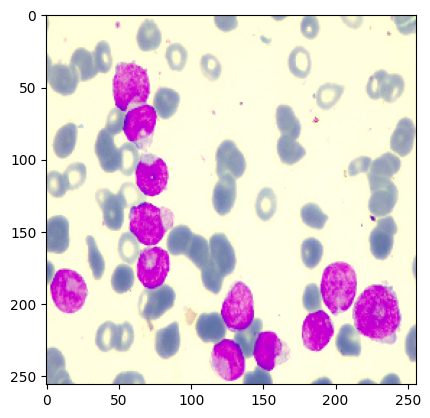

In [ ]:
img_url = DATASET_PATH +"/train/2785LAM24.jpeg"
a, b , c= dataset_c[13]
raw_image = np.array(a)
raw_mask = np.array(b)
plt.imshow(raw_image)
plt.show()

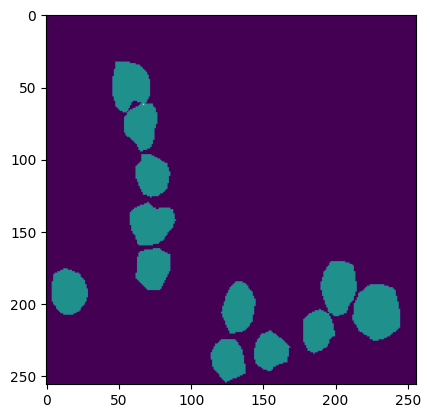

In [ ]:
plt.imshow(raw_mask)
plt.show()

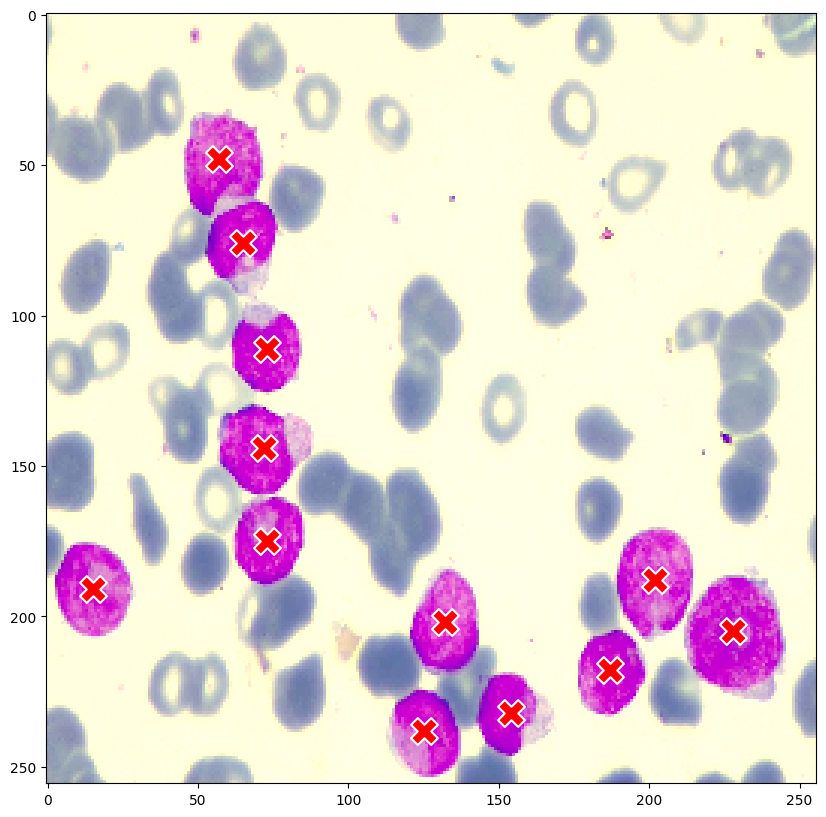

In [ ]:
input_points = [c]

# Visualize a single point.
show_points_on_image(raw_image, input_points[0])

# Prepare SAM Segmentaion Dataset (Data For Fine-Tune Model)

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    image,mask   = self.dataset[idx]
    image = np.array(image)
    ground_truth_mask = np.array(mask)

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_dataset = SAMDataset(dataset=dataset, processor=processor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

# Fine-Tune Model

### Load the model

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

### Model Inference before fine-tune

In [ ]:
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

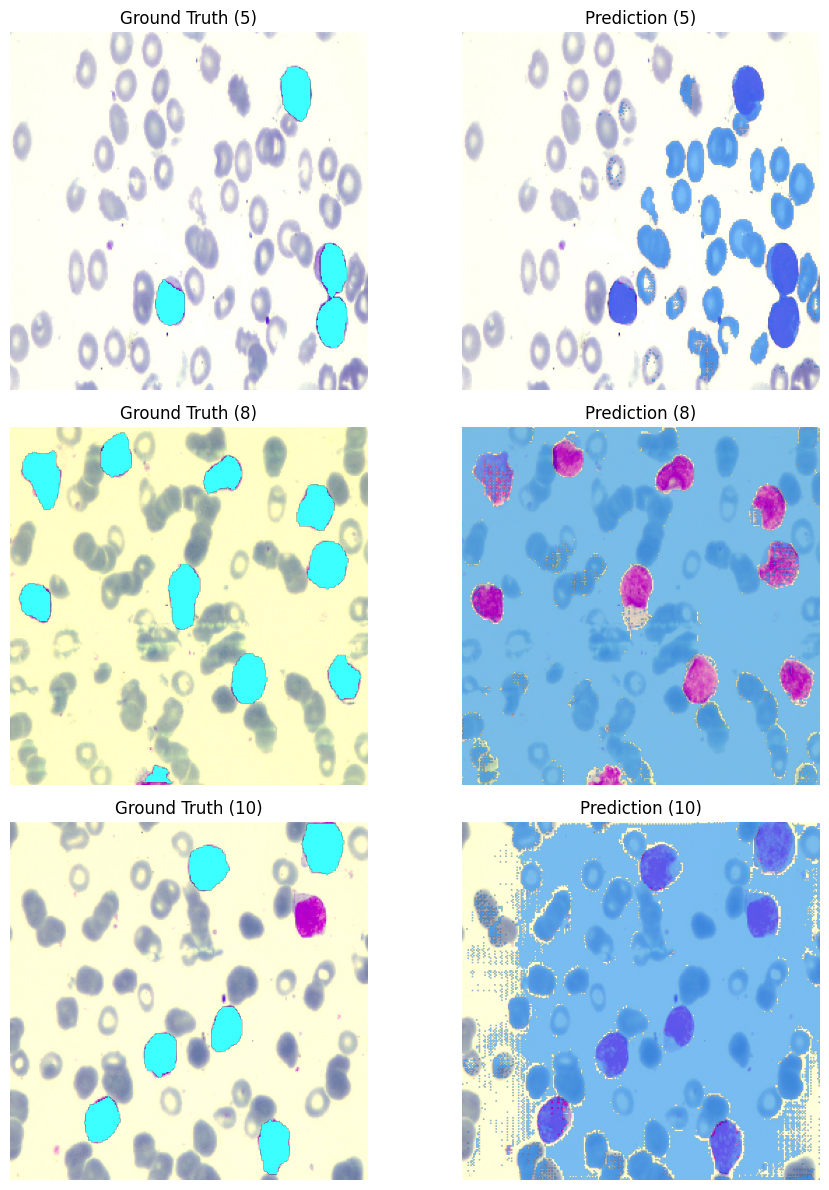

In [ ]:
indices = [5, 8, 10]


fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, idx in enumerate(indices):
    row = i
    col = 0

    # get ground truth and predicted masks
    image = dataset[idx][0]
    ground_truth_mask = np.array(dataset[idx][1])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    #ground truth mask
    axes[row, col].imshow(np.array(image))
    show_mask(ground_truth_mask, axes[row, col])
    axes[row, col].set_title(f"Ground Truth ({idx})")
    axes[row, col].axis("off")

    # predicted mask
    axes[row, col + 1].imshow(np.array(image))
    show_mask(medsam_seg, axes[row, col + 1])
    axes[row, col + 1].set_title(f"Prediction ({idx})")
    axes[row, col + 1].axis("off")


plt.tight_layout()
plt.show()

### Train the model

In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai


optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 31/31 [01:03<00:00,  2.04s/it]


EPOCH: 0
Mean loss: 0.6738283470753701


100%|██████████| 31/31 [00:39<00:00,  1.29s/it]


EPOCH: 1
Mean loss: 0.22318619970352419


100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


EPOCH: 2
Mean loss: -0.048435950952191505


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 3
Mean loss: -0.8646702336207512


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 4
Mean loss: -5.166851334033474


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 5
Mean loss: -19.031189401303568


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 6
Mean loss: -39.71075350238431


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 7
Mean loss: -67.33979106045538


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 8
Mean loss: -92.21691019304338


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 9
Mean loss: -112.21957147505975


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 10
Mean loss: -133.36003396587986


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 11
Mean loss: -156.65772732611626


100%|██████████| 31/31 [00:46<00:00,  1.49s/it]


EPOCH: 12
Mean loss: -175.6631058031513


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 13
Mean loss: -196.5574099402274


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 14
Mean loss: -216.93974047322428


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 15
Mean loss: -236.78389798441242


100%|██████████| 31/31 [00:38<00:00,  1.24s/it]


EPOCH: 16
Mean loss: -254.04309749603271


100%|██████████| 31/31 [00:39<00:00,  1.28s/it]


EPOCH: 17
Mean loss: -276.82568936194144


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 18
Mean loss: -296.6785092815276


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 19
Mean loss: -315.7415270036267


100%|██████████| 31/31 [00:38<00:00,  1.23s/it]


EPOCH: 20
Mean loss: -346.6067722228266


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 21
Mean loss: -394.3091052039977


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 22
Mean loss: -387.27928369275986


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 23
Mean loss: -401.89314366925146


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 24
Mean loss: -443.61275074558876


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 25
Mean loss: -451.3205639008553


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 26
Mean loss: -475.8410654683267


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 27
Mean loss: -540.4963378752432


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 28
Mean loss: -526.8796298580785


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 29
Mean loss: -554.3807701910696


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 30
Mean loss: -606.477881585398


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 31
Mean loss: -610.0153996867518


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 32
Mean loss: -688.5246586030529


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 33
Mean loss: -689.4243915927026


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 34
Mean loss: -698.2757671110091


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 35
Mean loss: -774.1589352392381


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 36
Mean loss: -836.4355452445245


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 37
Mean loss: -785.3415184020996


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 38
Mean loss: -826.484135289346


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 39
Mean loss: -864.6568642585509


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 40
Mean loss: -906.5818643569946


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 41
Mean loss: -979.8221037464757


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 42
Mean loss: -1030.667974656628


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 43
Mean loss: -1041.6701458654095


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 44
Mean loss: -1066.4215504738593


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 45
Mean loss: -1107.9545015519666


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 46
Mean loss: -1191.042064174529


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 47
Mean loss: -1200.7817127166256


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 48
Mean loss: -1252.9123692358694


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 49
Mean loss: -1301.6888277915216


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 50
Mean loss: -1380.0597816282702


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 51
Mean loss: -1400.7162115958429


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 52
Mean loss: -1448.359627016129


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 53
Mean loss: -1461.4213893028998


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 54
Mean loss: -1544.2591427218529


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 55
Mean loss: -1610.863888986649


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 56
Mean loss: -1675.8554569982714


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 57
Mean loss: -1737.0400788707118


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 58
Mean loss: -1937.289922160487


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 59
Mean loss: -1868.3358255817045


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 60
Mean loss: -1937.7064148995184


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 61
Mean loss: -2096.036024093628


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 62
Mean loss: -2104.452435739579


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 63
Mean loss: -2136.282161958756


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 64
Mean loss: -2241.4020647233533


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 65
Mean loss: -2337.629596402568


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 66
Mean loss: -2356.3475163675125


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 67
Mean loss: -2436.508463182757


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 68
Mean loss: -2517.7897972599153


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 69
Mean loss: -2757.4704011486424


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 70
Mean loss: -2686.3803086742278


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 71
Mean loss: -2877.1327341756514


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 72
Mean loss: -2870.016716495637


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 73
Mean loss: -2949.2487594235326


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 74
Mean loss: -3092.662145122405


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 75
Mean loss: -3368.5750690890895


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 76
Mean loss: -3377.7509641954975


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 77
Mean loss: -3352.9162658568353


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 78
Mean loss: -3454.393133255743


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 79
Mean loss: -3760.116239793839


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 80
Mean loss: -3657.0854744142102


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 81
Mean loss: -3760.071642660326


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 82
Mean loss: -3863.843401662765


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 83
Mean loss: -3906.694081644858


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 84
Mean loss: -4055.6228588165777


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 85
Mean loss: -4389.020885313711


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 86
Mean loss: -4331.328238887171


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 87
Mean loss: -4459.142642590307


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 88
Mean loss: -4582.646576619917


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 89
Mean loss: -4711.968409538269


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 90
Mean loss: -5033.012459355016


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 91
Mean loss: -5036.303746408032


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 92
Mean loss: -5176.781953196371


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 93
Mean loss: -5254.7558253195975


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 94
Mean loss: -5393.774269350113


100%|██████████| 31/31 [00:37<00:00,  1.22s/it]


EPOCH: 95
Mean loss: -6058.789622399115


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 96
Mean loss: -5678.355520463759


100%|██████████| 31/31 [00:37<00:00,  1.20s/it]


EPOCH: 97
Mean loss: -5799.6448792488345


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]


EPOCH: 98
Mean loss: -5962.855767311588


100%|██████████| 31/31 [00:37<00:00,  1.21s/it]

EPOCH: 99
Mean loss: -6108.00796474949


## Sam Inference After Fine-Tune

In [ ]:
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

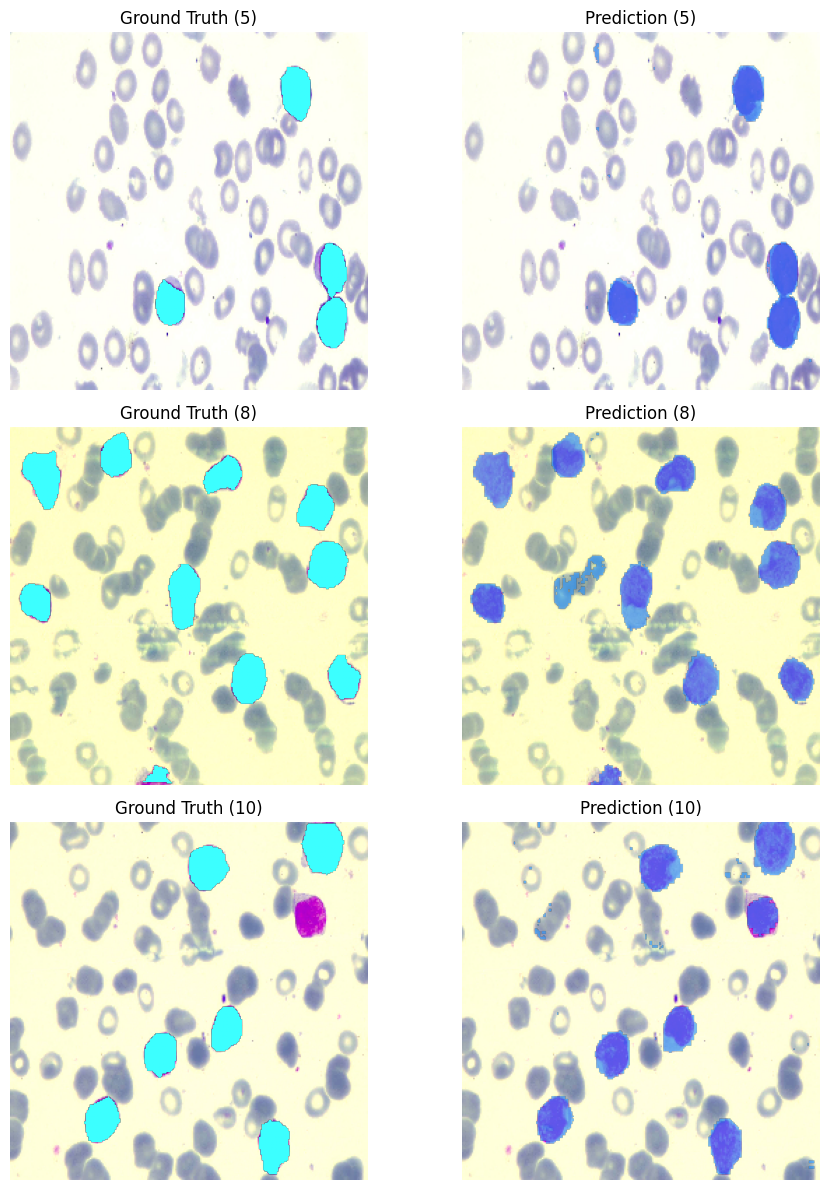

In [ ]:
indices = [5, 8, 10]


fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, idx in enumerate(indices):
    row = i
    col = 0

    # get ground truth and predicted masks
    image = dataset[idx][0]
    ground_truth_mask = np.array(dataset[idx][1])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    #ground truth mask
    axes[row, col].imshow(np.array(image))
    show_mask(ground_truth_mask, axes[row, col])
    axes[row, col].set_title(f"Ground Truth ({idx})")
    axes[row, col].axis("off")

    # predicted mask
    axes[row, col + 1].imshow(np.array(image))
    show_mask(medsam_seg, axes[row, col + 1])
    axes[row, col + 1].set_title(f"Prediction ({idx})")
    axes[row, col + 1].axis("off")


plt.tight_layout()
plt.show()

# Model Evaluation

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_recall_curve

def calculate_iou(ground_truth_mask, predicted_mask):

  intersection = np.logical_and(ground_truth_mask, predicted_mask).sum()
  union = np.logical_or(ground_truth_mask, predicted_mask).sum()
  iou = intersection / (union + 1e-6)
  return iou

def calculate_pixel_accuracy(ground_truth_mask, predicted_mask):

  correct_pixels = np.sum(ground_truth_mask == predicted_mask)
  total_pixels = ground_truth_mask.size()
  pixel_accuracy = correct_pixels / total_pixels
  return pixel_accuracy


### Traning Dataset

In [ ]:
root_dir =os.path.join( DATASET_PATH,'train')
ann_file =os.path.join( root_dir,'instances_default.json')


# training  dataset
training_dataset = BloodCellSegmentationDataset2(root_dir, ann_file, transforms=None)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:

ious = []
pixel_accuracies = []

traning_results = []
for image, ground_truth_mask in training_dataset:

    # prediction mask
    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # metrics
    iou = calculate_iou(ground_truth_mask, medsam_seg)
    traning_results.append((ground_truth_mask, medsam_seg, medsam_seg_prob))

    ious.append(iou)

traning_mean_iou = np.mean(ious)
overall_pixel_accuracy = np.mean(pixel_accuracies)



/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Validation Dataset

In [ ]:
root_dir =os.path.join( DATASET_PATH,'val')
ann_file =os.path.join( root_dir,'instances_default.json')


# val  dataset
val_dataset = BloodCellSegmentationDataset2(root_dir, ann_file, transforms=None)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [ ]:

ious = []
pixel_accuracies = []

results = []
for image, ground_truth_mask in val_dataset:

    # prediction mask
    prompt = get_bounding_box(ground_truth_mask)
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    # metrics
    iou = calculate_iou(ground_truth_mask, medsam_seg)
    results.append((ground_truth_mask, medsam_seg, medsam_seg_prob))

    ious.append(iou)


mean_iou = np.mean(ious)
overall_pixel_accuracy = np.mean(pixel_accuracies)




In [ ]:
print(f"Mean IoU: {mean_iou}")

Mean IoU: 0.7105376720428467


In [ ]:
import pandas as pd
df = pd.DataFrame([] , columns = ["IOU", "MAP_0.75"], index=["Training Data","Validation Data"])

In [ ]:
gt_masks_flat = np.concatenate([gt_mask.flatten() for gt_mask, _,_ in results])
pred_masks_flat = np.concatenate([pred_mask.flatten() for _,_ ,pred_mask in results])

gt_targets = gt_masks_flat.astype(bool).astype(int)
pred_masks_binary = (pred_masks_flat > 0.75).astype(int)

precision = precision_score(gt_targets, pred_masks_binary)
recall = recall_score(gt_targets, pred_masks_binary)
f1 = f1_score(gt_targets, pred_masks_binary)

# mAP at   threshold
map_at_75 = f1
print(f"Mean Average Precision (mAP) at 0.75 threshold: {map_at_75:.4f}")

Mean Average Precision (mAP) at 0.75 threshold: 0.8000


In [ ]:
gt_masks_flat = np.concatenate([gt_mask.flatten() for gt_mask, _,_ in traning_results])
pred_masks_flat = np.concatenate([pred_mask.flatten() for _,_ ,pred_mask in traning_results])

gt_targets = gt_masks_flat.astype(bool).astype(int)
pred_masks_binary = (pred_masks_flat > 0.75).astype(int)

precision = precision_score(gt_targets, pred_masks_binary)
recall = recall_score(gt_targets, pred_masks_binary)
f1 = f1_score(gt_targets, pred_masks_binary)

# mAP at   threshold
training_map_at_75 = f1
print(f"Mean Average Precision (mAP) at 0.75 threshold: {training_map_at_75:.4f}")


Mean Average Precision (mAP) at 0.75 threshold: 0.8967


In [ ]:
df.loc['Validation Data'] = [mean_iou,map_at_75]
df.loc['Training Data'] = [traning_mean_iou,training_map_at_75]

In [ ]:
df

,IOU,MAP_0.75
Training Data,0.819019,0.896725
Validation Data,0.710538,0.800008
